# A1_3 – MLR and PyTorch comparison against manual BP

In this notebook we compare three regression models on the same dataset:

- Multiple Linear Regression (MLR) using scikit-learn
- A custom neural network implemented from scratch (manual backprop)
- A neural network implemented with PyTorch

The goals are:

- Use exactly the same preprocessed data for all models.
- Reuse the best configuration found for the manual BP network in the previous notebook.
- Train MLR and PyTorch with comparable settings.
- Compare the models using MSE, MAE and MAPE on:
  - the 80% train+validation set,
  - the 20% test set.
- Visualize error curves and prediction quality with scatter plots.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
base = os.path.dirname(os.getcwd())  
sys.path.append(os.path.join(base, "models"))
sys.path.append(os.path.join(base, "utils"))

import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import predict_batch, mape, evaluate_regression
from NeuralNet import NeuralNet                      # manual BP implementation
from mlr_sklearn import MultipleLinearRegressionSK   # simple MLR wrapper
from neuralnet_torch import NeuralNetTorch           # PyTorch implementation



In [2]:

# Load preprocessed data from ./data

X_trainval_np = np.load("../data/X_trainval_np.npy")
X_test_np     = np.load("../data/X_test_np.npy")

y_trainval = np.load("../data/y_trainval.npy")
y_test     = np.load("../data/y_test.npy")

y_trainval_scaled = np.load("../data/y_trainval_scaled.npy")
y_test_scaled     = np.load("../data/y_test_scaled.npy")

x_scaler = joblib.load("../data/x_scaler.joblib")
y_scaler = joblib.load("../data/y_scaler.joblib")

n_features = X_trainval_np.shape[1]
print("Loaded preprocessed data from ../data")
print("X_trainval_np:", X_trainval_np.shape)
print("X_test_np    :", X_test_np.shape)
print("n_features   :", n_features)

Loaded preprocessed data from ../data
X_trainval_np: (1200, 61)
X_test_np    : (300, 61)
n_features   : 61


In [3]:
# Selected configuration for manual BP, we copy here the desired Hyperpaarameters from the notebook 2

hidden_layers_bp = [40, 15]
epochs_bp = 600
lr_bp = 0.005
momentum_bp = 0.9
activation_bp = "tanh"

print("Manual BP selected configuration:")
print("Hidden layers :", hidden_layers_bp)
print("Epochs        :", epochs_bp)
print("Learning rate :", lr_bp)
print("Momentum      :", momentum_bp)
print("Activation    :", activation_bp)


Manual BP selected configuration:
Hidden layers : [40, 15]
Epochs        : 600
Learning rate : 0.005
Momentum      : 0.9
Activation    : tanh


In [4]:

# 1) Manual Backprop Neural Network (selected config)


layers_bp = [n_features] + hidden_layers_bp + [1]

net_manual = NeuralNet(
    n=layers_bp,
    fact=activation_bp,
    eta=lr_bp,
    alpha=momentum_bp,
    epochs=epochs_bp,
    val_split=0.2
)

# Train on the 80% (network internally splits into train/val)
net_manual.fit(X_trainval_np, y_trainval_scaled)

# Error evolution per epoch (from NeuralNet)
train_err_manual, val_err_manual = net_manual.loss_epochs()

# --- Predictions in scaled space ---
y_trainval_pred_manual_scaled = predict_batch(net_manual, X_trainval_np)
y_test_pred_manual_scaled     = predict_batch(net_manual, X_test_np)

# --- Back to original target scale (cnt_log) ---
y_trainval_pred_manual = y_scaler.inverse_transform(y_trainval_pred_manual_scaled).ravel()
y_test_pred_manual     = y_scaler.inverse_transform(y_test_pred_manual_scaled).ravel()

# --- Metrics (in original cnt_log scale) ---
metrics_manual_trainval = evaluate_regression(y_trainval, y_trainval_pred_manual)
metrics_manual_test     = evaluate_regression(y_test,     y_test_pred_manual)

print("=== Manual BP Neural Network (selected config) ===")
print("TRAIN+VAL:", metrics_manual_trainval)
print("TEST     :", metrics_manual_test)


Neural network has been initialized
Architecture (neurons per layer): [61, 40, 15, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(15, 40), theta(15, 1)
 Layer 3: w(1, 15), theta(1, 1)
Epoch 0: Train MSE=0.108205 | Val MSE=0.051376
Epoch 100: Train MSE=0.000828 | Val MSE=0.017717
Epoch 200: Train MSE=0.000109 | Val MSE=0.016002
Epoch 300: Train MSE=0.000062 | Val MSE=0.016148
Epoch 400: Train MSE=0.000046 | Val MSE=0.016237
Epoch 500: Train MSE=0.000079 | Val MSE=0.016304
=== Manual BP Neural Network (selected config) ===
TRAIN+VAL: {'MSE': 0.013309866583710335, 'MAE': 0.03961036737936923, 'MAPE': 1.3962633121345875}
TEST     : {'MSE': 0.10414316759813087, 'MAE': 0.15697394611576623, 'MAPE': 7.72476770647717}


In [5]:

# 2) Multiple Linear Regression (scikit-learn)


mlr = MultipleLinearRegressionSK(fit_intercept=True)

# Train on scaled features and scaled target (same as neural networks)
mlr.fit(X_trainval_np, y_trainval_scaled)

# Predictions in scaled space
y_trainval_pred_mlr_scaled = mlr.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_mlr_scaled     = mlr.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_mlr = y_scaler.inverse_transform(y_trainval_pred_mlr_scaled).ravel()
y_test_pred_mlr     = y_scaler.inverse_transform(y_test_pred_mlr_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_mlr_trainval = evaluate_regression(y_trainval, y_trainval_pred_mlr)
metrics_mlr_test     = evaluate_regression(y_test,     y_test_pred_mlr)

print("=== Multiple Linear Regression (scikit-learn) ===")
print("TRAIN+VAL:", metrics_mlr_trainval)
print("TEST     :", metrics_mlr_test)


Multiple Linear Regression (scikit-learn) initialized.
fit_intercept: True
=== Multiple Linear Regression (scikit-learn) ===
TRAIN+VAL: {'MSE': 0.20247073221894374, 'MAE': 0.31618385284837797, 'MAPE': 10.62239601387907}
TEST     : {'MSE': 0.22018721386256748, 'MAE': 0.3201973636727165, 'MAPE': 12.332372304806857}


In [6]:

# 3) PyTorch Neural Network (same config as manual BP)


hidden_layers_torch = hidden_layers_bp
layers_torch = [n_features] + hidden_layers_torch + [1]

net_torch = NeuralNetTorch(
    n=layers_torch,
    fact=activation_bp,   # same activation
    eta=lr_bp,            # same learning rate
    alpha=momentum_bp,    # same momentum
    epochs=epochs_bp,     # same number of epochs
    val_split=0.2         # same validation split
)

# Train with scaled data
net_torch.fit(X_trainval_np, y_trainval_scaled)

# Loss history for later plots
train_err_torch, val_err_torch = net_torch.loss_epochs()

# Predictions in scaled space
y_trainval_pred_torch_scaled = net_torch.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_torch_scaled     = net_torch.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_torch = y_scaler.inverse_transform(y_trainval_pred_torch_scaled).ravel()
y_test_pred_torch     = y_scaler.inverse_transform(y_test_pred_torch_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_torch_trainval = evaluate_regression(y_trainval, y_trainval_pred_torch)
metrics_torch_test     = evaluate_regression(y_test,     y_test_pred_torch)

print("=== PyTorch Neural Network (same config) ===")
print("TRAIN+VAL:", metrics_torch_trainval)
print("TEST     :", metrics_torch_test)


NeuralNetTorch (PyTorch) initialized
 - Layers: [61, 40, 15, 1]
 - Activation: tanh
 - Learning rate: 0.005 | Momentum: 0.9
 - Epochs: 600 | Val split: 0.2
Epoch 0: Train MSE=1.083025 | Val MSE=0.978162
Epoch 100: Train MSE=0.085831 | Val MSE=0.122366
Epoch 200: Train MSE=0.073163 | Val MSE=0.109590
Epoch 300: Train MSE=0.063567 | Val MSE=0.098432
Epoch 400: Train MSE=0.055152 | Val MSE=0.087943
Epoch 500: Train MSE=0.047471 | Val MSE=0.077774
=== PyTorch Neural Network (same config) ===
TRAIN+VAL: {'MSE': 0.09086596669230182, 'MAE': 0.19737159674195273, 'MAPE': 7.259625117916895}
TEST     : {'MSE': 0.12820550850568355, 'MAE': 0.2187763658806339, 'MAPE': 9.33229632740983}


In [7]:

# Comparison tables: TRAIN+VAL and TEST metrics


results_trainval = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_trainval["MSE"],
        metrics_mlr_trainval["MSE"],
        metrics_torch_trainval["MSE"],
    ],
    "MAE":   [
        metrics_manual_trainval["MAE"],
        metrics_mlr_trainval["MAE"],
        metrics_torch_trainval["MAE"],
    ],
    "MAPE":  [
        metrics_manual_trainval["MAPE"],
        metrics_mlr_trainval["MAPE"],
        metrics_torch_trainval["MAPE"],
    ],
}

results_test = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_test["MSE"],
        metrics_mlr_test["MSE"],
        metrics_torch_test["MSE"],
    ],
    "MAE":   [
        metrics_manual_test["MAE"],
        metrics_mlr_test["MAE"],
        metrics_torch_test["MAE"],
    ],
    "MAPE":  [
        metrics_manual_test["MAPE"],
        metrics_mlr_test["MAPE"],
        metrics_torch_test["MAPE"],
    ],
}

df_trainval = pd.DataFrame(results_trainval)
df_test     = pd.DataFrame(results_test)

print("=== TRAIN+VAL metrics (80%) ===")
display(df_trainval)

print("=== TEST metrics (20%) ===")
display(df_test)


=== TRAIN+VAL metrics (80%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.013310,0.039610,1.396263
1,MLR (SK),0.202471,0.316184,10.622396
2,PyTorch NN,0.090866,0.197372,7.259625


=== TEST metrics (20%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.104143,0.156974,7.724768
1,MLR (SK),0.220187,0.320197,12.332372
2,PyTorch NN,0.128206,0.218776,9.332296


### Loss curves for the BP models

In these plots we show how the error changes during the training process.

- The first figure shows the **training** and **validation** MSE for our manual BP implementation.
- The second figure shows the same curves for the **PyTorch BP model**.

If the curves go down smoothly, the model is learning in a stable way.  
If training keeps going down but validation goes up, the model is overfitting.  
If both curves stay high, the hyperparameters are not good enough or the model is too simple.


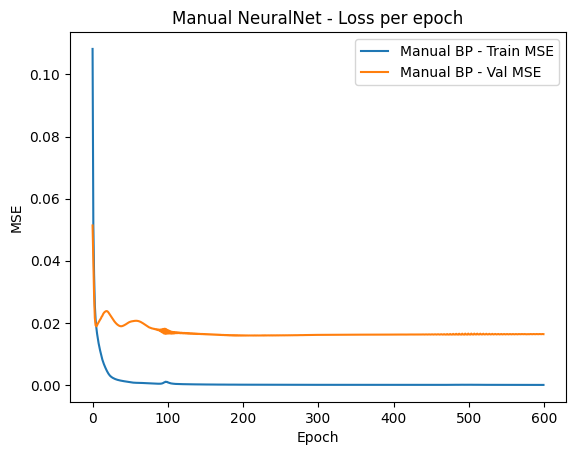

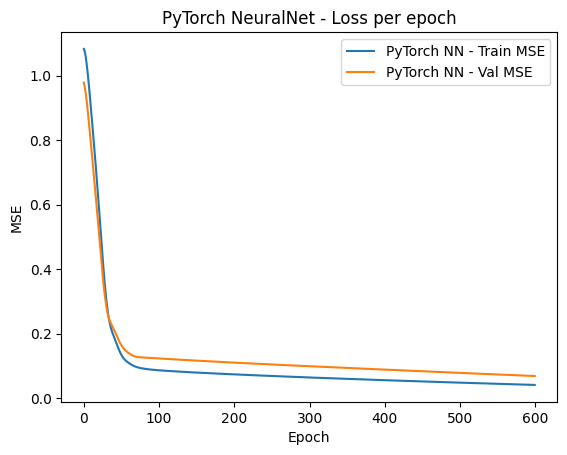

In [8]:

# Loss curves for manual BP and PyTorch

plt.figure()
plt.plot(train_err_manual, label="Manual BP - Train MSE")
if any(e is not None for e in val_err_manual):
    plt.plot([e for e in val_err_manual if e is not None], label="Manual BP - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Manual NeuralNet - Loss per epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_err_torch, label="PyTorch NN - Train MSE")
if any(e is not None for e in val_err_torch):
    plt.plot([e for e in val_err_torch if e is not None], label="PyTorch NN - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("PyTorch NeuralNet - Loss per epoch")
plt.legend()
plt.show()


### Scatter plots: predicted vs real values (test set)

In these figures we compare the real target values from the test set with the predicted values from each model.  
Each point represents one sample in the test set.

- If the points are close to the diagonal line, the prediction is good.
- If the points are far from the diagonal, the model is making large errors.
- A more compact and diagonal pattern means better generalization.

We show the scatter plot for the three models:

1. **Manual BP** – our own implementation of backpropagation.  
2. **MLR** – the multiple linear regression baseline.  
3. **PyTorch NN** – the neural network using a library implementation.

By comparing the three plots we can understand which model performs best and how
their errors are distributed.


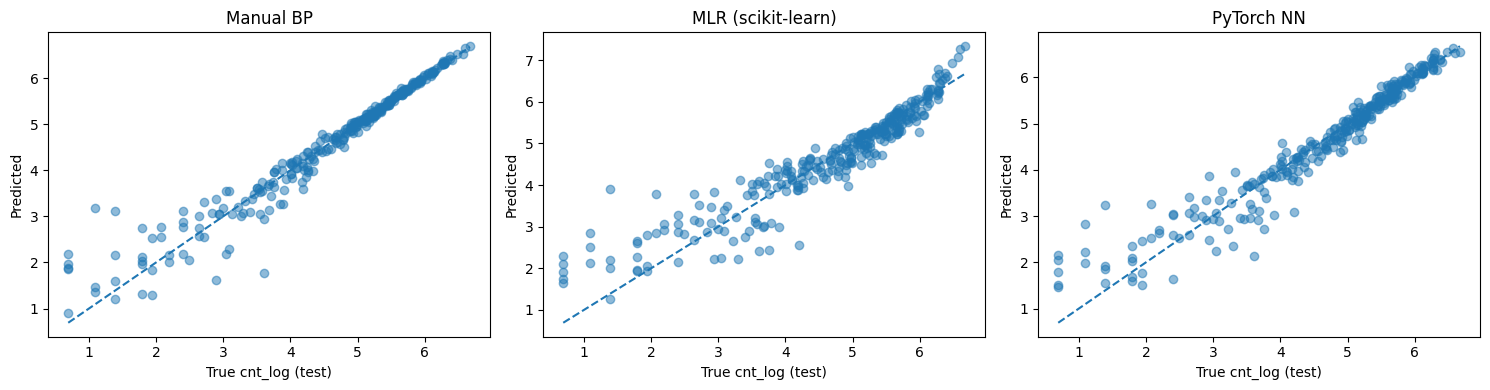

In [10]:

# Scatter plots: true vs predicted on TEST set


plt.figure(figsize=(15, 4))

# Manual BP
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_manual, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("Manual BP")

# MLR
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_mlr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("MLR (scikit-learn)")

# PyTorch NN
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_torch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("PyTorch NN")

plt.tight_layout()
plt.show()


## Summary of model comparison

In this notebook we compared three regression models on the same
Bike Sharing hourly dataset:

- **Manual BP Neural Network** (custom implementation),
- **Multiple Linear Regression (MLR)** using scikit-learn,
- **PyTorch Neural Network** using the same architecture and hyperparameters as the manual BP model.

The main points are:

- All models were trained on the same **scaled** features and target.
- The manual BP and the PyTorch models used the same:
  - number of layers and neurons,
  - activation function,
  - learning rate, momentum,
  - number of epochs,
  - internal validation split.
- We measured performance using **MSE, MAE and MAPE** on:
  - the 80% train+validation set,
  - the 20% test set.

From the comparison tables and plots we can discuss:

- How the linear model (MLR) behaves compared to the nonlinear neural networks.
- Whether PyTorch reproduces or improves the performance of the manual BP implementation.
- How stable each model is during training (by looking at the loss curves).
- How close the predictions are to the true values on the test set (scatter plots).

